# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [22]:
! pip install Pillow

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [24]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [25]:
!ls MNIST

processed  raw


In [26]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


<ipython-input-26-6143b94785d1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [27]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

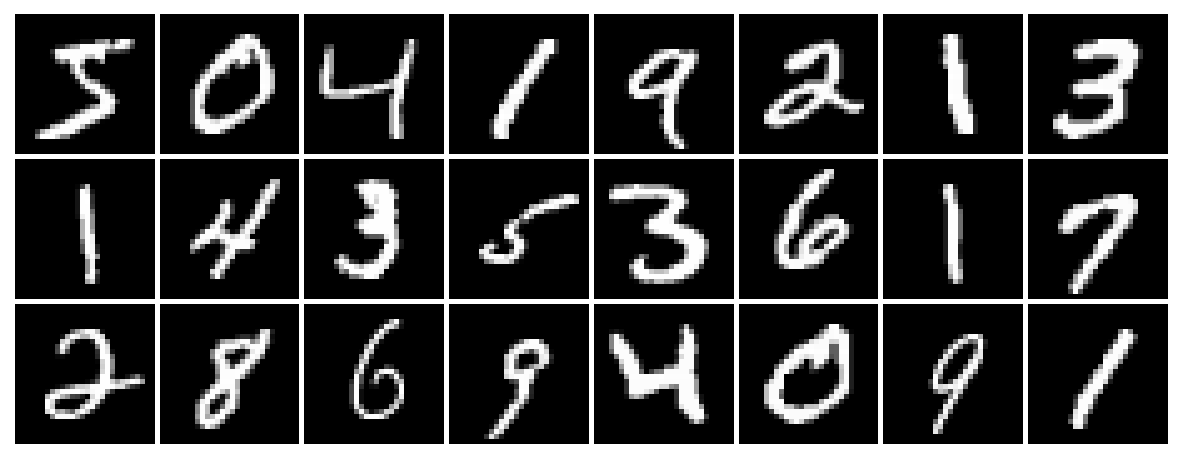

In [28]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


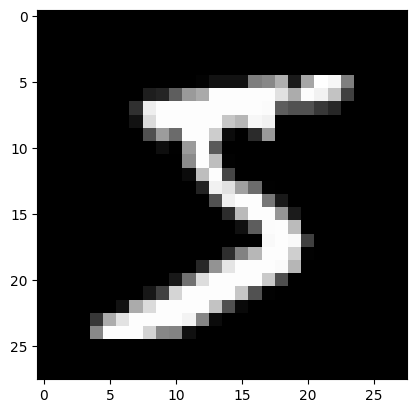

In [29]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [30]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [31]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 0.0549,  0.3106,  0.2097, -0.0821, -0.1642, -0.0128,  0.0337, -0.1737,
          0.0633,  0.1081],
        [-0.0999,  0.1419,  0.1879, -0.3211, -0.2655, -0.0537,  0.1356, -0.2030,
          0.1662, -0.1080],
        [-0.1151,  0.3442, -0.2649, -0.0813, -0.0838,  0.0118,  0.1211,  0.0705,
          0.1264,  0.2501],
        [-0.1543,  0.0699, -0.1964,  0.2281,  0.0163,  0.0139,  0.1867,  0.1881,
          0.0287, -0.1392],
        [-0.1406,  0.1149, -0.2776,  0.0622, -0.2318,  0.0242,  0.1138,  0.0921,
         -0.0353,  0.1198]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [32]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [33]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-ovu_79pv
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-ovu_79pv
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done


In [34]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3231, grad_fn=<NllLossBackward0>)

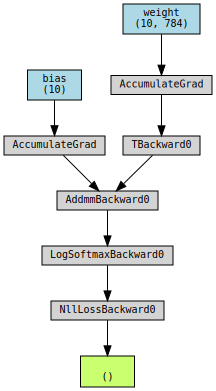

In [35]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [36]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [37]:
print('Final loss:', loss.item())

Final loss: 0.26417267322540283


### Visualizando gráfico de perda durante o treinamento

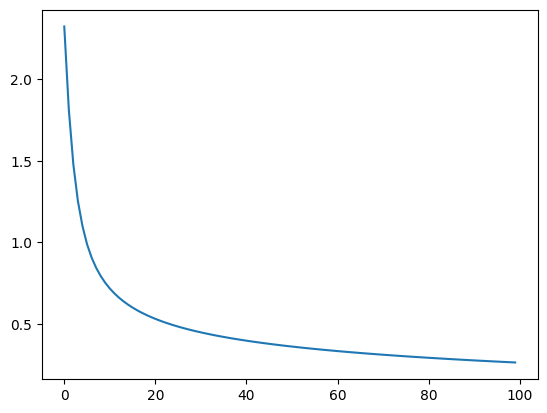

In [38]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [39]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.94


### Matriz de confusão com dados de treinamento e teste

In [40]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,2,3,1,0
2,0,1,91,1,0,1,0,1,2,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,1,2,0,3
5,0,2,0,1,0,81,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,110,0,3
8,0,2,2,0,0,2,0,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


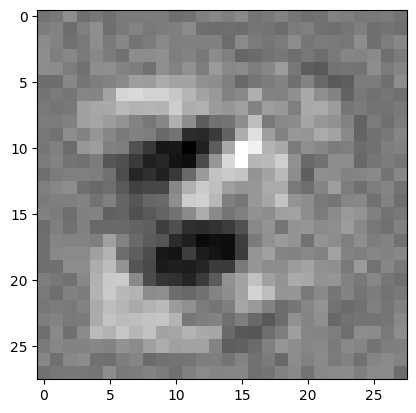

In [41]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

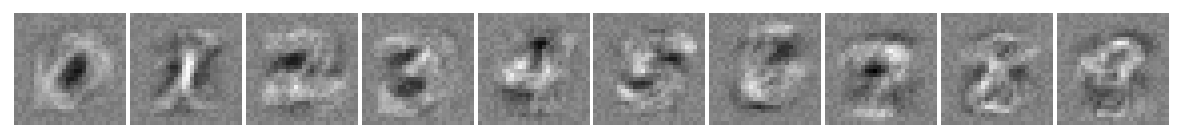

In [42]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [44]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    # Impressão dos resultados ao final da época
    print(f"Época {i + 1}/{epochs} - Perda: {loss.item():.4f} - Acurácia: {accuracy:.4f}")

Época 1/100 - Perda: 0.1774 - Acurácia: 0.9680
Época 2/100 - Perda: 0.1768 - Acurácia: 0.9680
Época 3/100 - Perda: 0.1762 - Acurácia: 0.9680
Época 4/100 - Perda: 0.1757 - Acurácia: 0.9680
Época 5/100 - Perda: 0.1751 - Acurácia: 0.9680
Época 6/100 - Perda: 0.1746 - Acurácia: 0.9680
Época 7/100 - Perda: 0.1740 - Acurácia: 0.9690
Época 8/100 - Perda: 0.1735 - Acurácia: 0.9690
Época 9/100 - Perda: 0.1729 - Acurácia: 0.9690
Época 10/100 - Perda: 0.1724 - Acurácia: 0.9690
Época 11/100 - Perda: 0.1718 - Acurácia: 0.9700
Época 12/100 - Perda: 0.1713 - Acurácia: 0.9700
Época 13/100 - Perda: 0.1708 - Acurácia: 0.9700
Época 14/100 - Perda: 0.1702 - Acurácia: 0.9700
Época 15/100 - Perda: 0.1697 - Acurácia: 0.9700
Época 16/100 - Perda: 0.1692 - Acurácia: 0.9700
Época 17/100 - Perda: 0.1687 - Acurácia: 0.9700
Época 18/100 - Perda: 0.1681 - Acurácia: 0.9700
Época 19/100 - Perda: 0.1676 - Acurácia: 0.9710
Época 20/100 - Perda: 0.1671 - Acurácia: 0.9710
Época 21/100 - Perda: 0.1666 - Acurácia: 0.9710
É

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

Epoch[1/100], loss: 0.262846, acc: 0.940000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


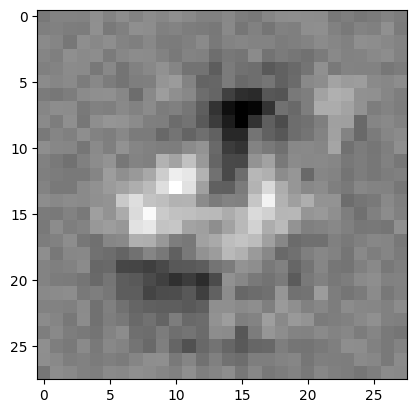

Epoch[2/100], loss: 0.261536, acc: 0.942000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


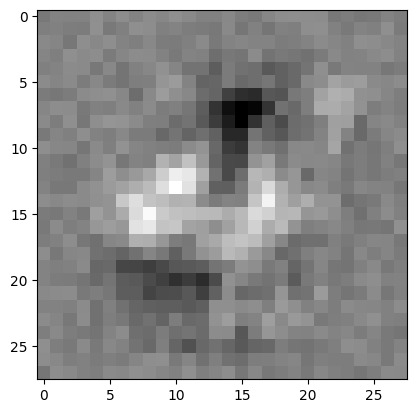

Epoch[3/100], loss: 0.260241, acc: 0.942000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


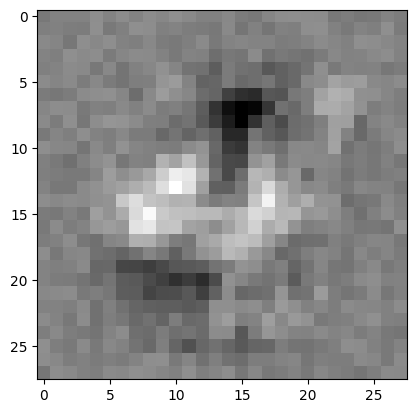

Epoch[4/100], loss: 0.258961, acc: 0.942000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


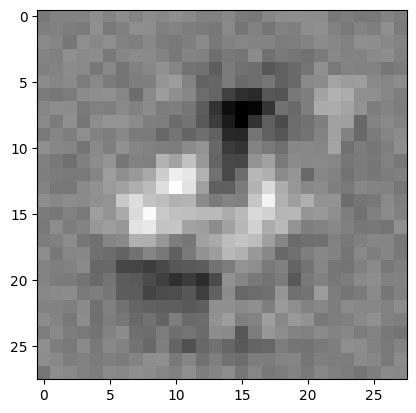

Epoch[5/100], loss: 0.257696, acc: 0.942000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


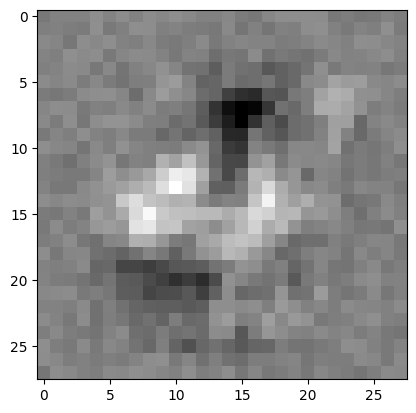

Epoch[6/100], loss: 0.256445, acc: 0.943000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


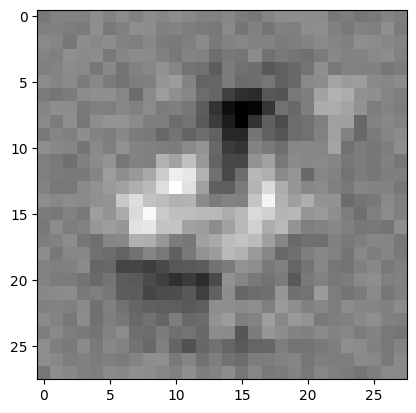

Epoch[7/100], loss: 0.255208, acc: 0.943000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


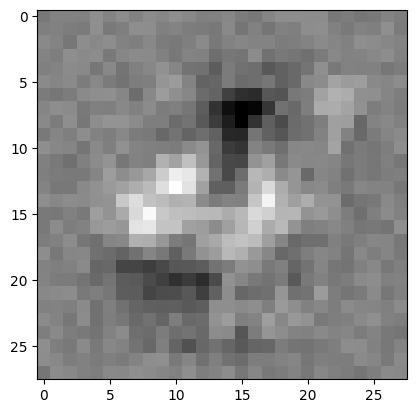

Epoch[8/100], loss: 0.253985, acc: 0.943000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


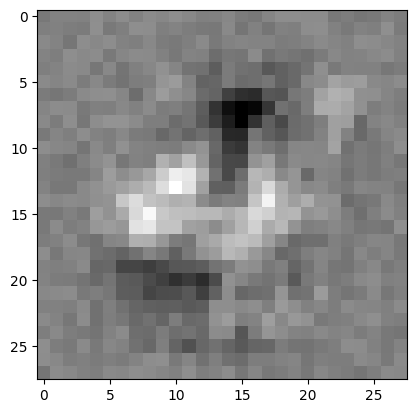

Epoch[9/100], loss: 0.252776, acc: 0.943000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


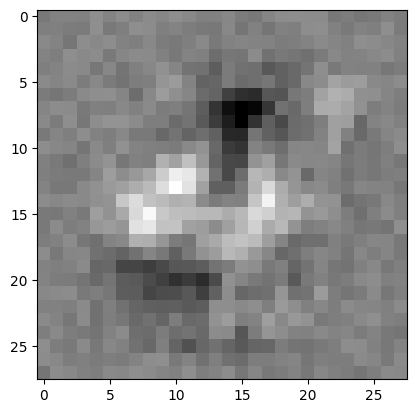

Epoch[10/100], loss: 0.251580, acc: 0.943000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


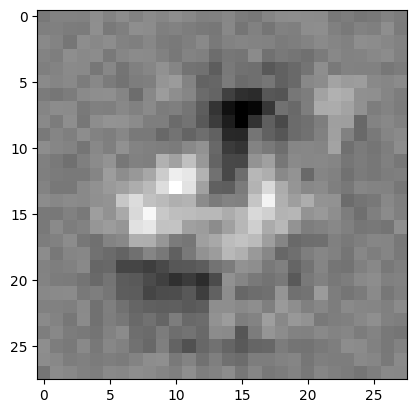

Epoch[11/100], loss: 0.250397, acc: 0.944000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


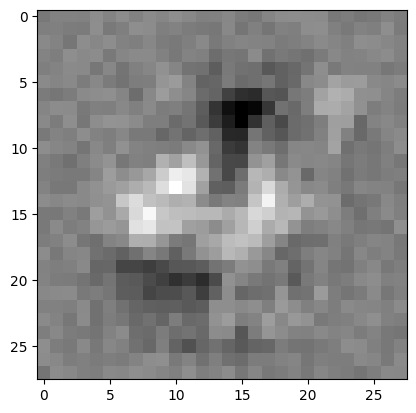

Epoch[12/100], loss: 0.249227, acc: 0.944000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


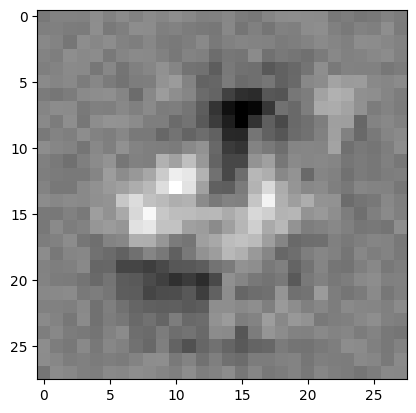

Epoch[13/100], loss: 0.248069, acc: 0.944000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


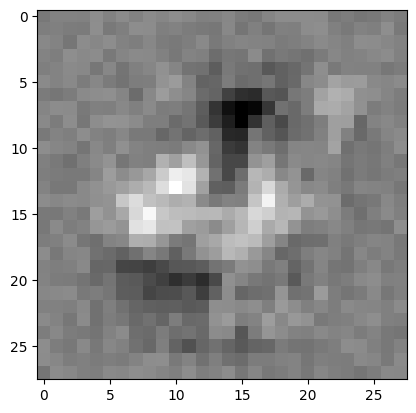

Epoch[14/100], loss: 0.246923, acc: 0.944000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


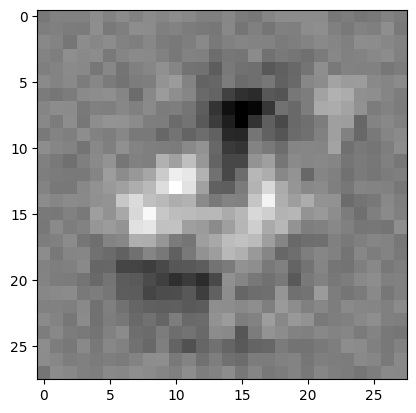

Epoch[15/100], loss: 0.245789, acc: 0.946000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


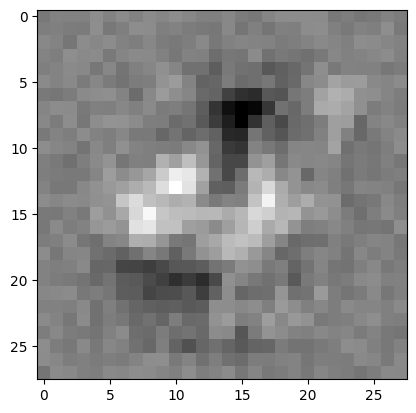

Epoch[16/100], loss: 0.244668, acc: 0.946000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


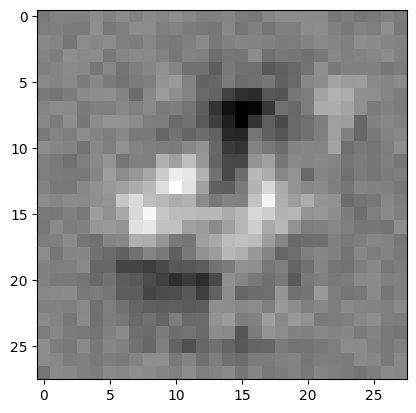

Epoch[17/100], loss: 0.243557, acc: 0.948000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


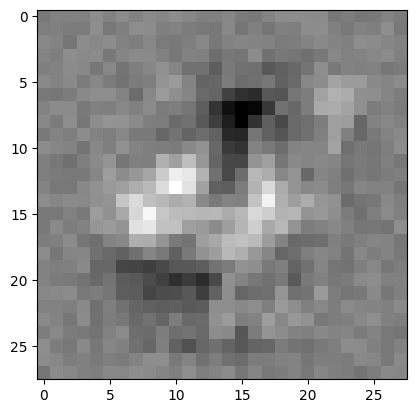

Epoch[18/100], loss: 0.242458, acc: 0.949000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


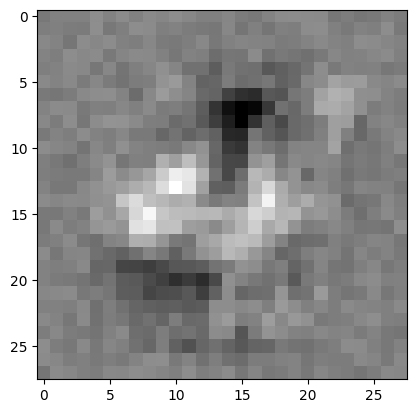

Epoch[19/100], loss: 0.241370, acc: 0.949000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


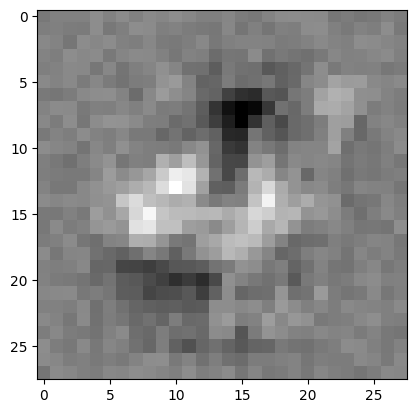

Epoch[20/100], loss: 0.240293, acc: 0.950000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


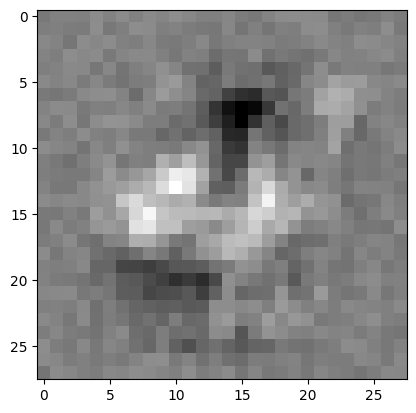

Epoch[21/100], loss: 0.239227, acc: 0.950000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


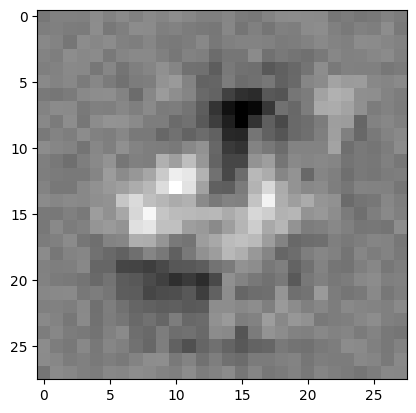

Epoch[22/100], loss: 0.238171, acc: 0.950000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


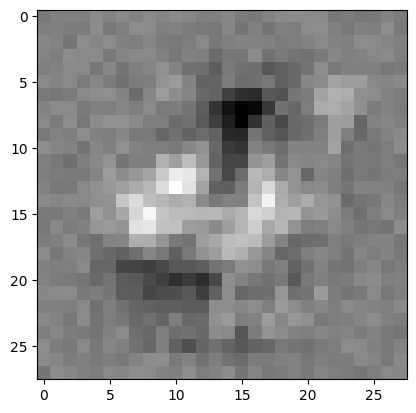

Epoch[23/100], loss: 0.237126, acc: 0.950000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


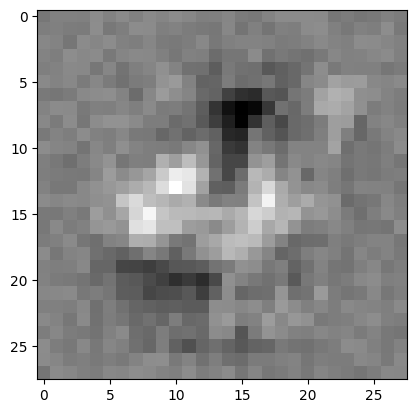

Epoch[24/100], loss: 0.236090, acc: 0.950000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


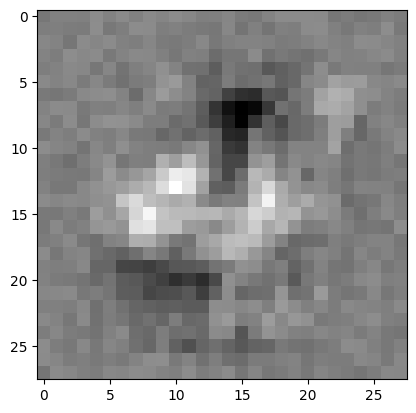

Epoch[25/100], loss: 0.235065, acc: 0.950000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


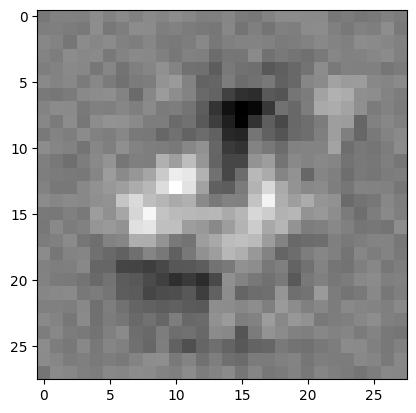

Epoch[26/100], loss: 0.234049, acc: 0.951000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


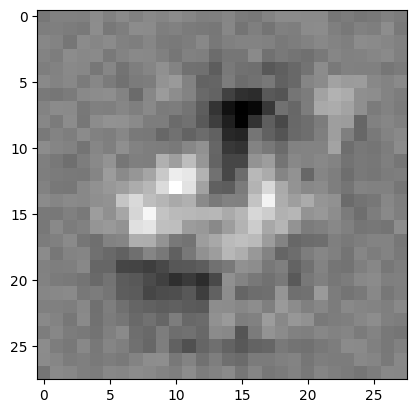

Epoch[27/100], loss: 0.233043, acc: 0.951000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


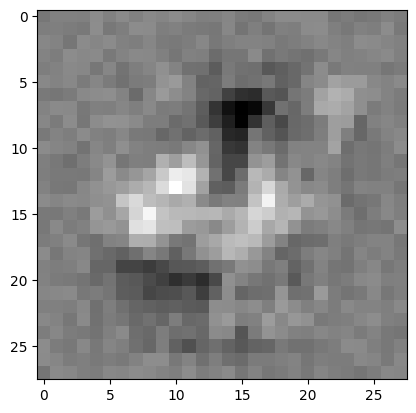

Epoch[28/100], loss: 0.232047, acc: 0.951000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


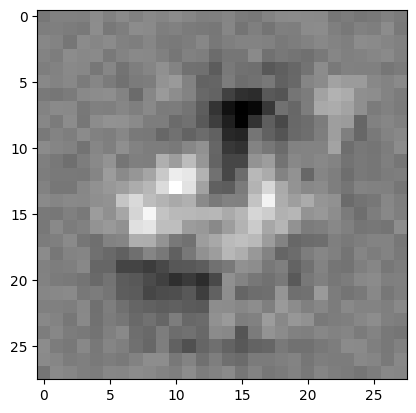

Epoch[29/100], loss: 0.231060, acc: 0.951000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


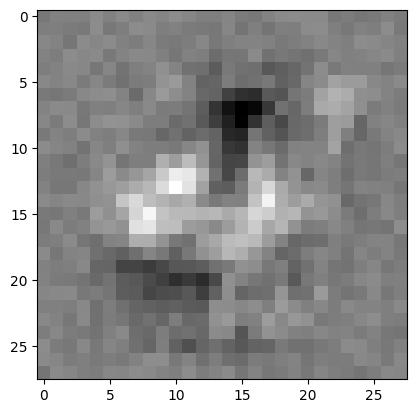

Epoch[30/100], loss: 0.230082, acc: 0.952000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


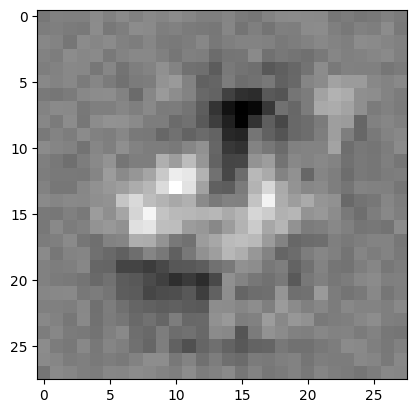

Epoch[31/100], loss: 0.229112, acc: 0.952000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


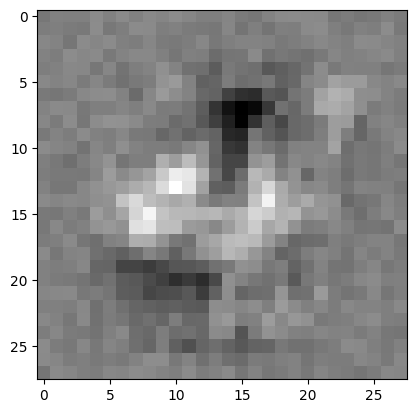

Epoch[32/100], loss: 0.228152, acc: 0.953000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


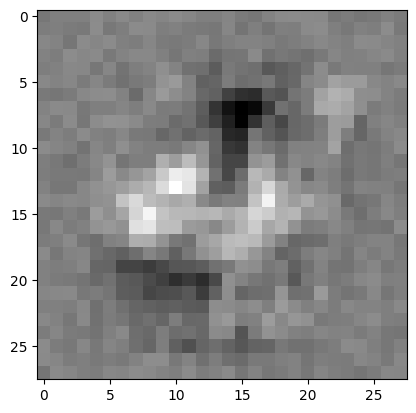

Epoch[33/100], loss: 0.227201, acc: 0.953000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


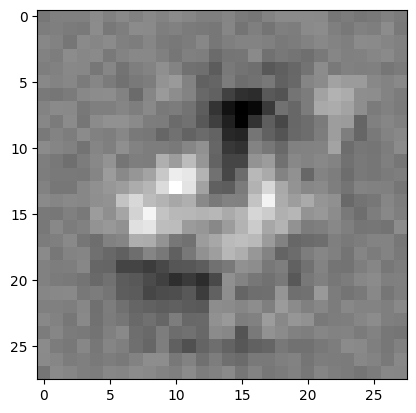

Epoch[34/100], loss: 0.226258, acc: 0.953000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


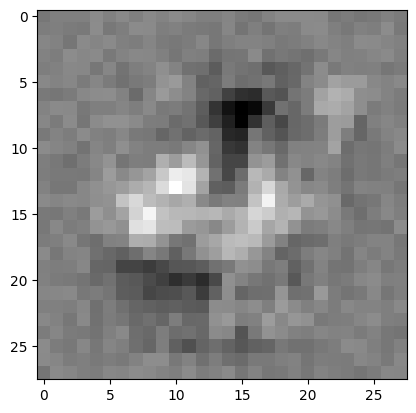

Epoch[35/100], loss: 0.225323, acc: 0.954000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


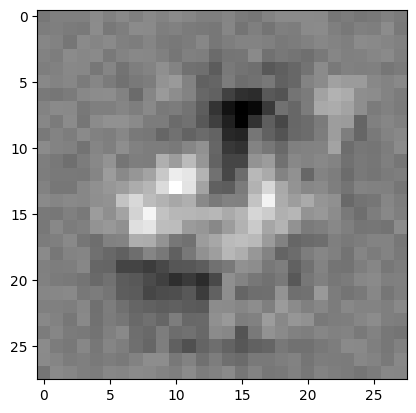

Epoch[36/100], loss: 0.224397, acc: 0.954000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


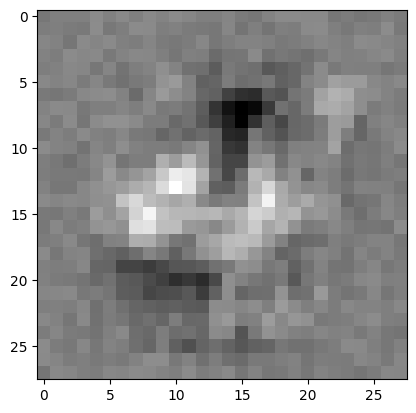

Epoch[37/100], loss: 0.223478, acc: 0.954000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


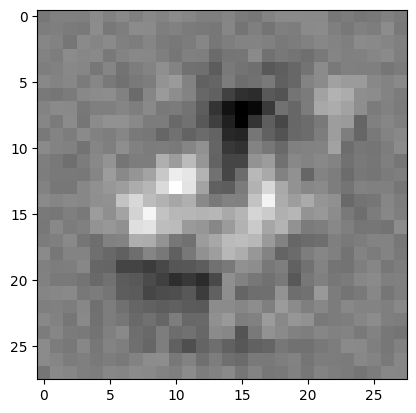

Epoch[38/100], loss: 0.222568, acc: 0.954000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


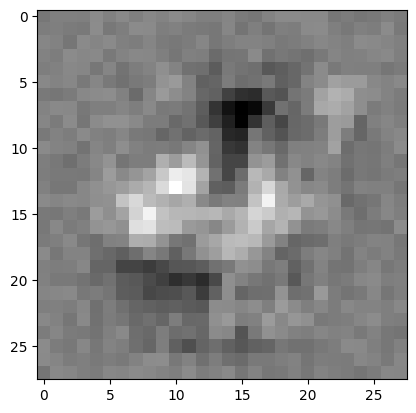

Epoch[39/100], loss: 0.221666, acc: 0.955000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


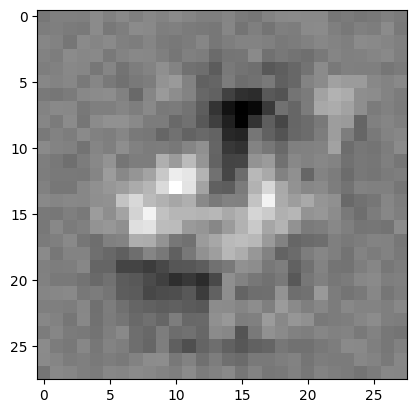

Epoch[40/100], loss: 0.220771, acc: 0.955000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


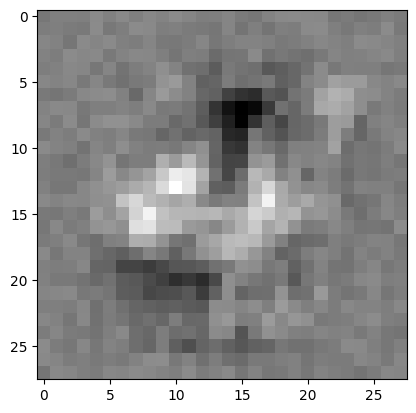

Epoch[41/100], loss: 0.219884, acc: 0.955000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


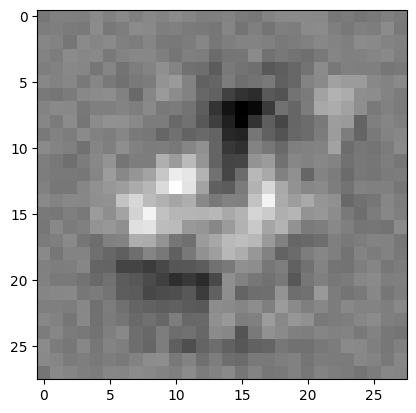

Epoch[42/100], loss: 0.219005, acc: 0.955000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


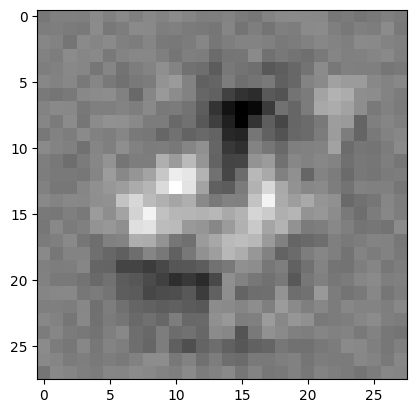

Epoch[43/100], loss: 0.218133, acc: 0.955000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


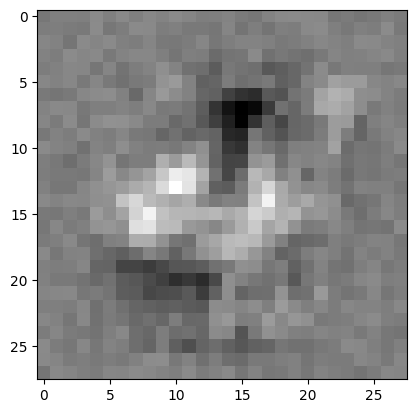

Epoch[44/100], loss: 0.217268, acc: 0.955000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


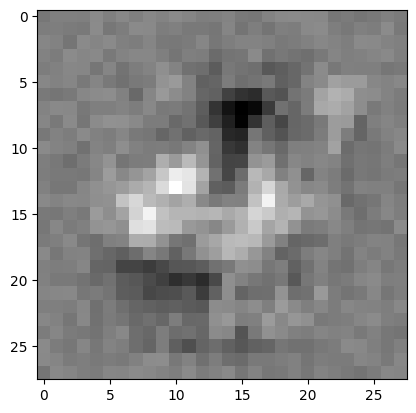

Epoch[45/100], loss: 0.216411, acc: 0.955000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


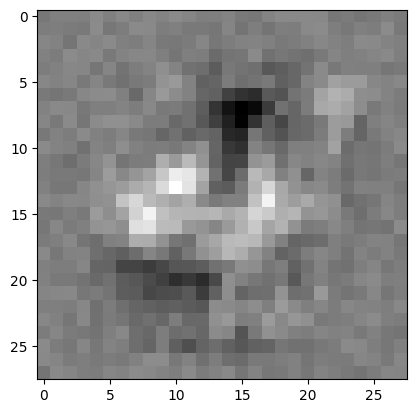

Epoch[46/100], loss: 0.215561, acc: 0.955000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


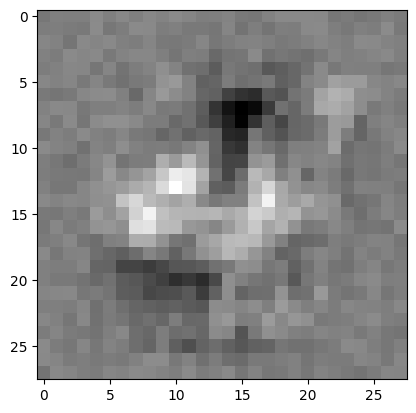

Epoch[47/100], loss: 0.214717, acc: 0.955000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


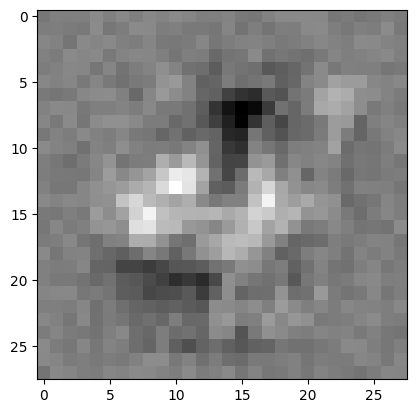

Epoch[48/100], loss: 0.213881, acc: 0.955000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


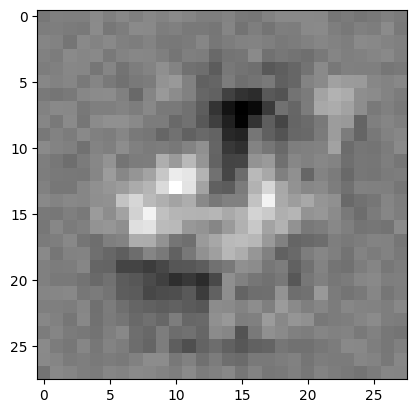

Epoch[49/100], loss: 0.213051, acc: 0.955000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


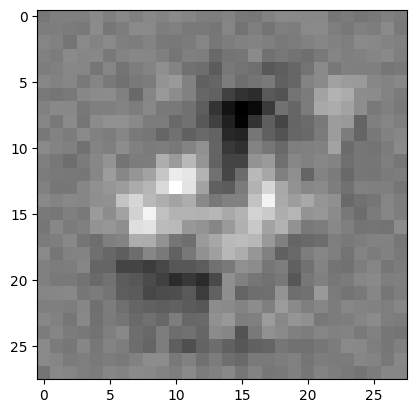

Epoch[50/100], loss: 0.212228, acc: 0.955000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


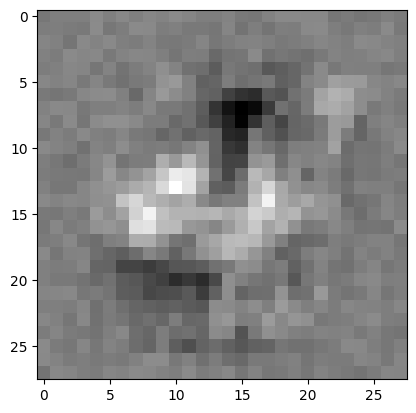

Epoch[51/100], loss: 0.211412, acc: 0.956000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


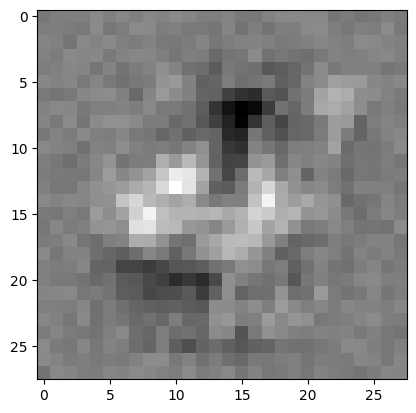

Epoch[52/100], loss: 0.210602, acc: 0.956000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


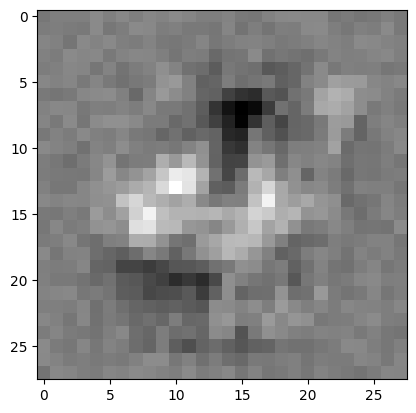

Epoch[53/100], loss: 0.209799, acc: 0.957000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


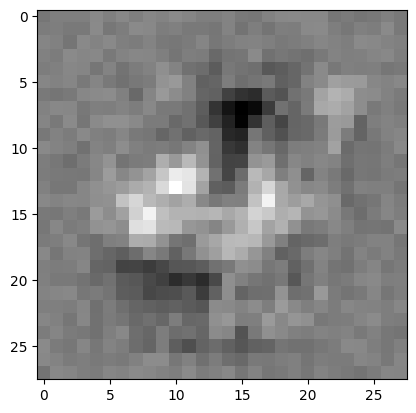

Epoch[54/100], loss: 0.209002, acc: 0.957000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


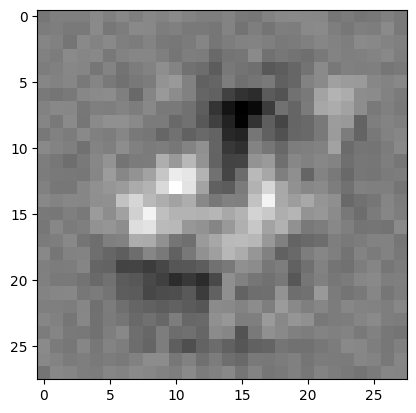

Epoch[55/100], loss: 0.208211, acc: 0.958000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


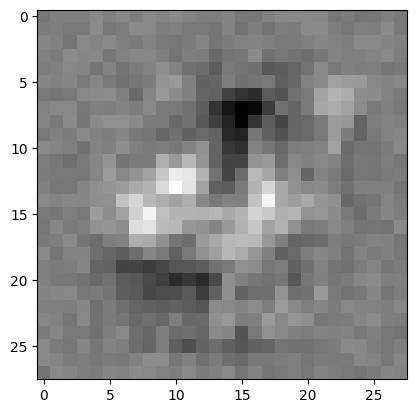

Epoch[56/100], loss: 0.207426, acc: 0.959000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


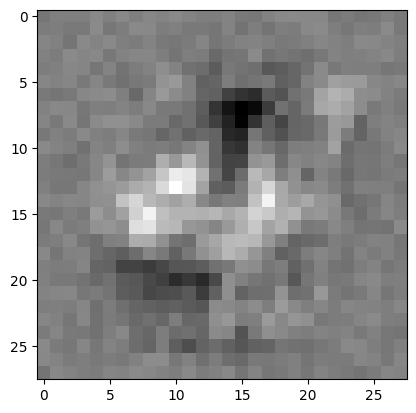

Epoch[57/100], loss: 0.206647, acc: 0.959000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


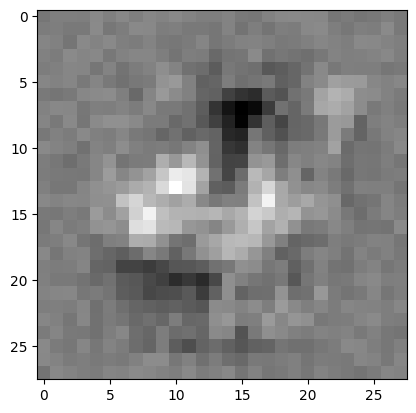

Epoch[58/100], loss: 0.205875, acc: 0.960000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


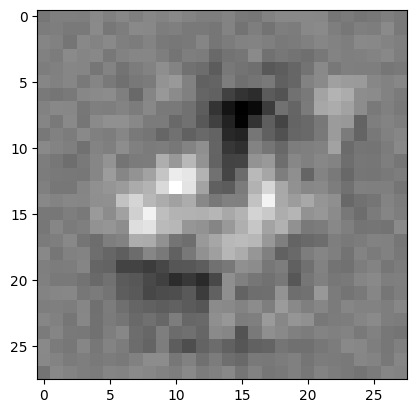

Epoch[59/100], loss: 0.205108, acc: 0.960000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


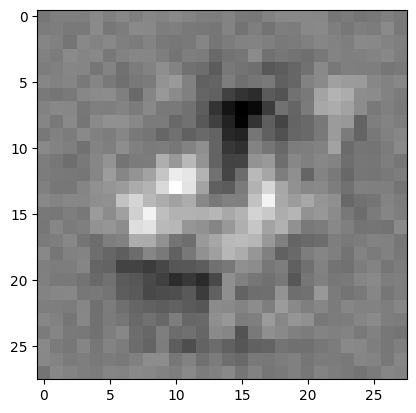

Epoch[60/100], loss: 0.204347, acc: 0.960000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


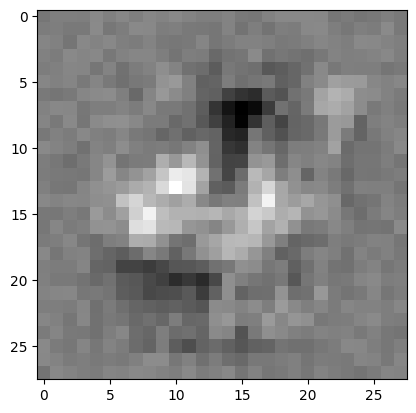

Epoch[61/100], loss: 0.203592, acc: 0.960000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


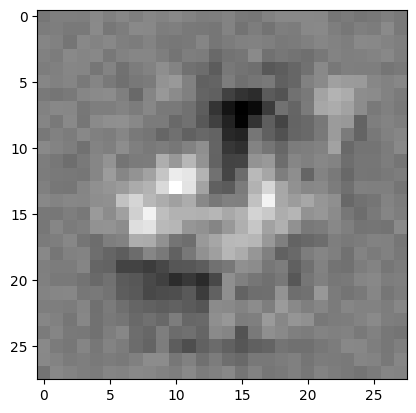

Epoch[62/100], loss: 0.202843, acc: 0.961000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


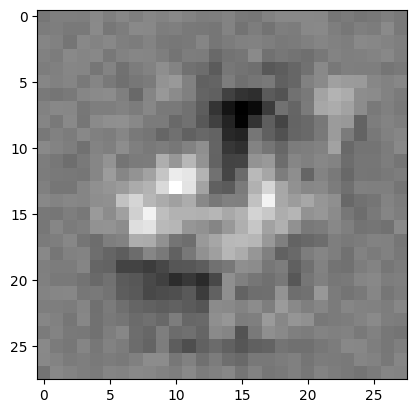

Epoch[63/100], loss: 0.202099, acc: 0.961000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


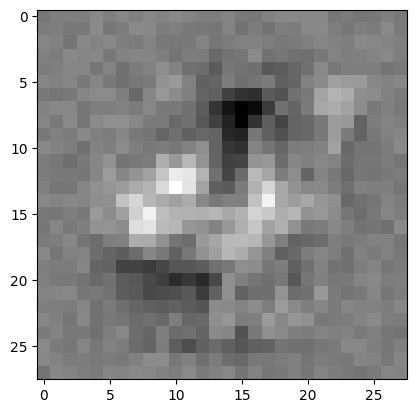

Epoch[64/100], loss: 0.201360, acc: 0.961000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


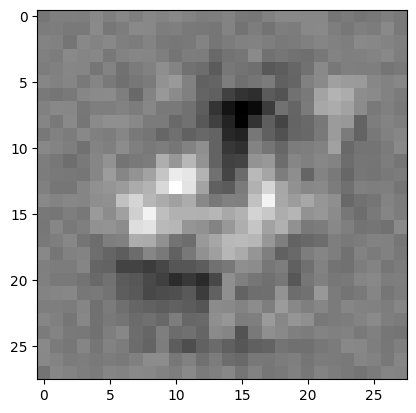

Epoch[65/100], loss: 0.200627, acc: 0.961000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


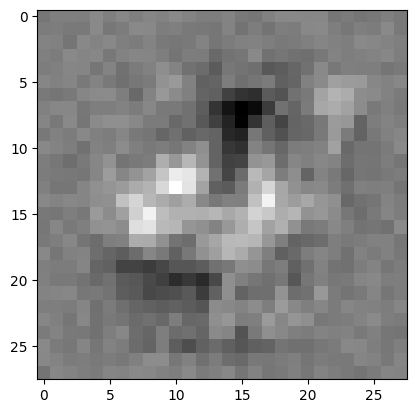

Epoch[66/100], loss: 0.199900, acc: 0.962000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


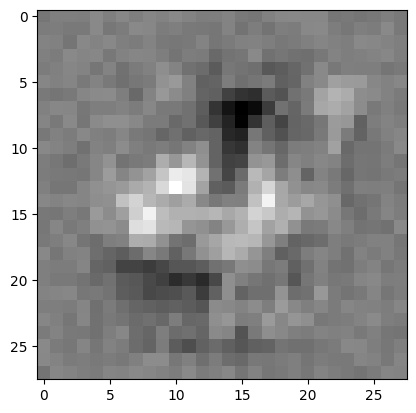

Epoch[67/100], loss: 0.199178, acc: 0.962000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


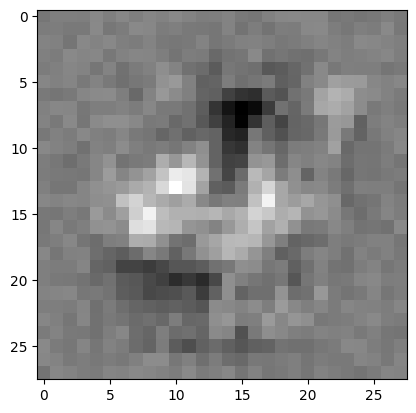

Epoch[68/100], loss: 0.198461, acc: 0.962000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


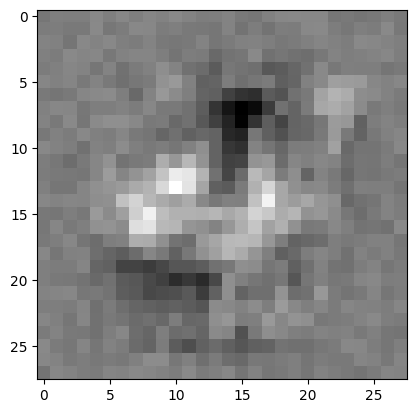

Epoch[69/100], loss: 0.197749, acc: 0.962000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


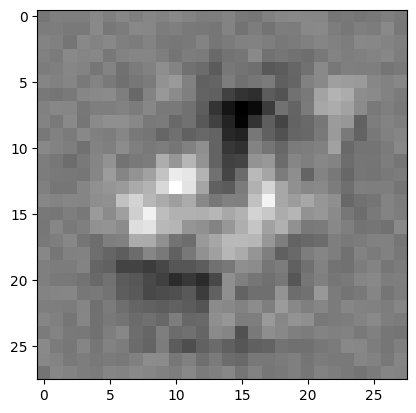

Epoch[70/100], loss: 0.197043, acc: 0.962000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


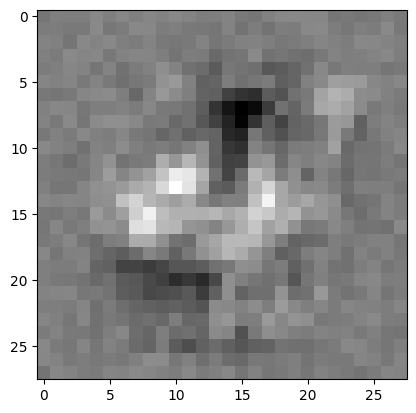

Epoch[71/100], loss: 0.196341, acc: 0.963000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


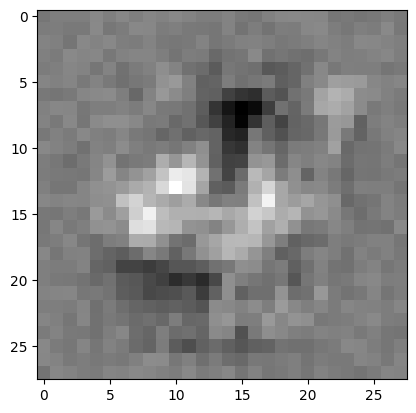

Epoch[72/100], loss: 0.195645, acc: 0.963000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


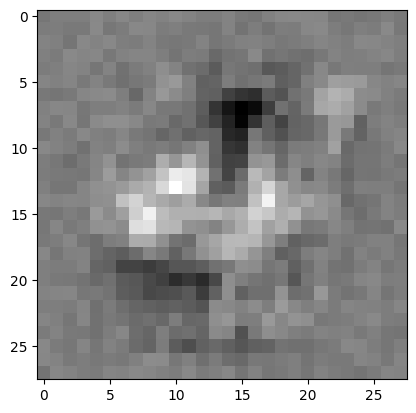

Epoch[73/100], loss: 0.194953, acc: 0.963000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


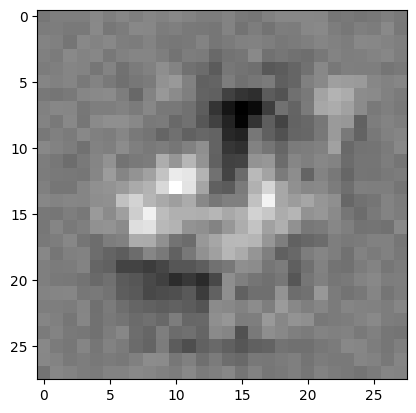

Epoch[74/100], loss: 0.194267, acc: 0.963000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


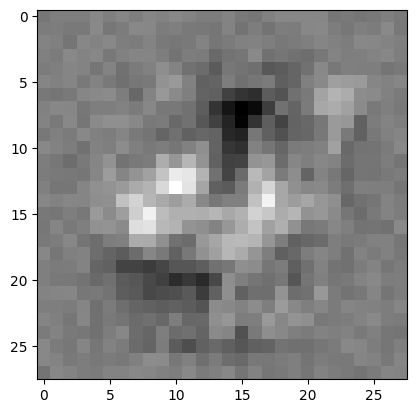

Epoch[75/100], loss: 0.193585, acc: 0.963000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


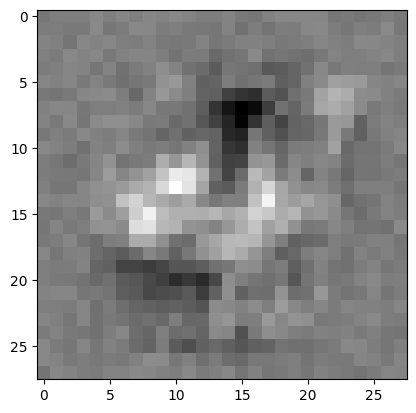

Epoch[76/100], loss: 0.192908, acc: 0.963000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


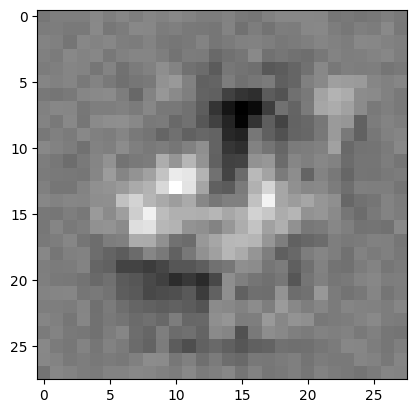

Epoch[77/100], loss: 0.192235, acc: 0.964000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


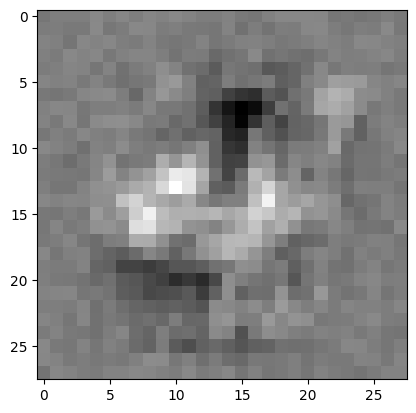

Epoch[78/100], loss: 0.191568, acc: 0.965000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


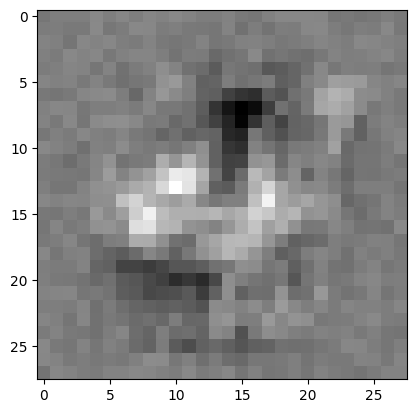

Epoch[79/100], loss: 0.190905, acc: 0.966000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


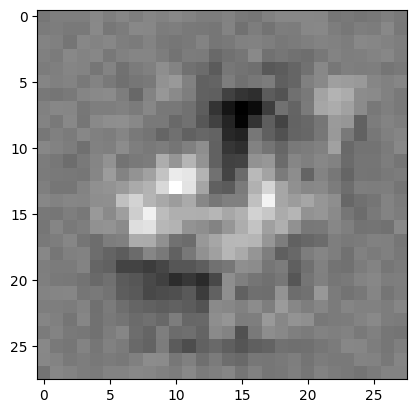

Epoch[80/100], loss: 0.190246, acc: 0.966000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


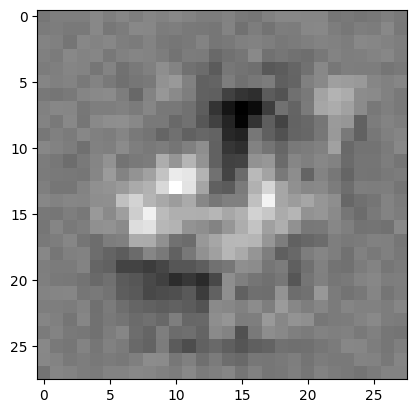

Epoch[81/100], loss: 0.189592, acc: 0.966000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


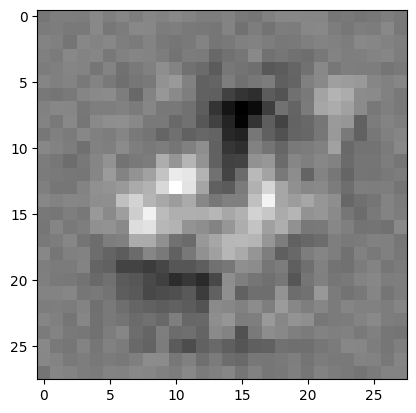

Epoch[82/100], loss: 0.188942, acc: 0.966000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


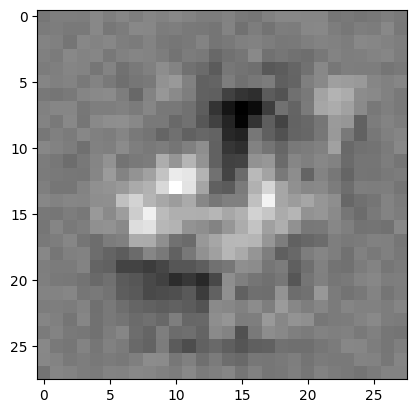

Epoch[83/100], loss: 0.188297, acc: 0.966000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


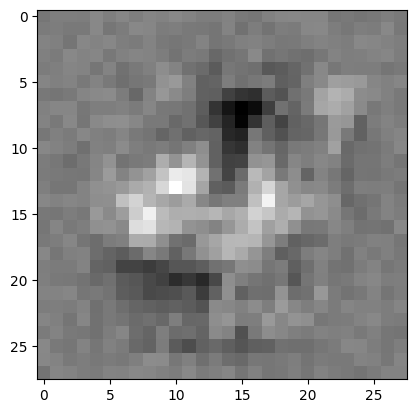

Epoch[84/100], loss: 0.187656, acc: 0.966000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


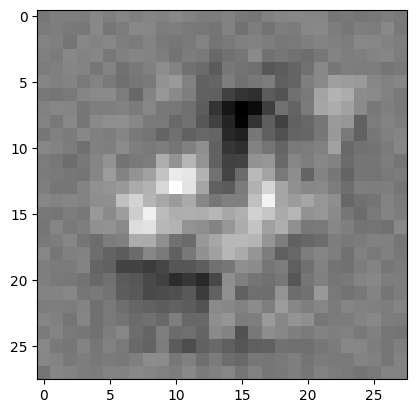

Epoch[85/100], loss: 0.187020, acc: 0.966000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


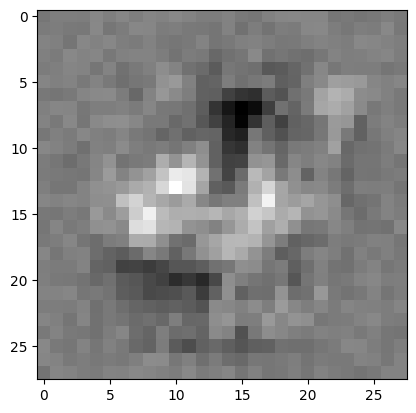

Epoch[86/100], loss: 0.186387, acc: 0.966000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


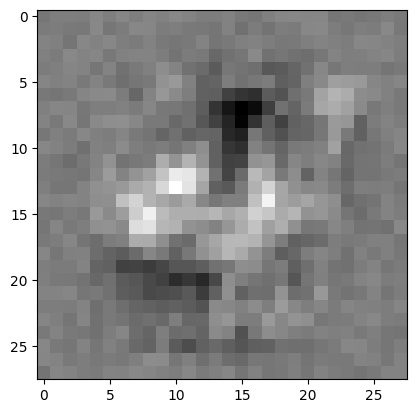

Epoch[87/100], loss: 0.185759, acc: 0.966000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


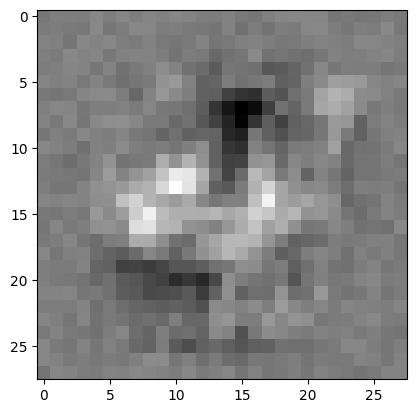

Epoch[88/100], loss: 0.185135, acc: 0.966000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


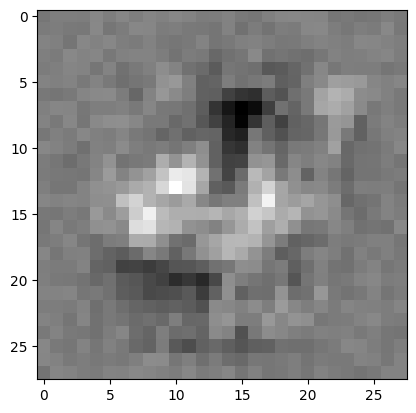

Epoch[89/100], loss: 0.184515, acc: 0.966000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


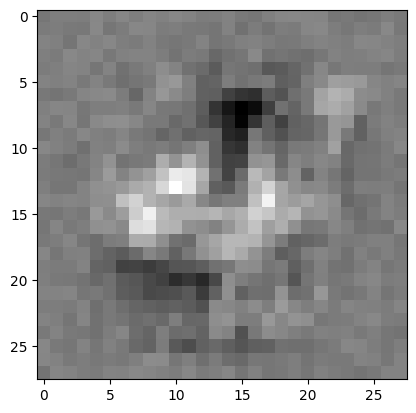

Epoch[90/100], loss: 0.183899, acc: 0.967000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


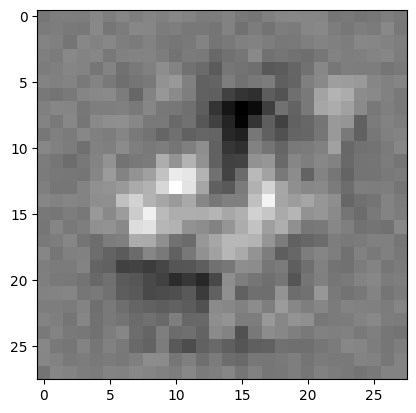

Epoch[91/100], loss: 0.183287, acc: 0.967000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


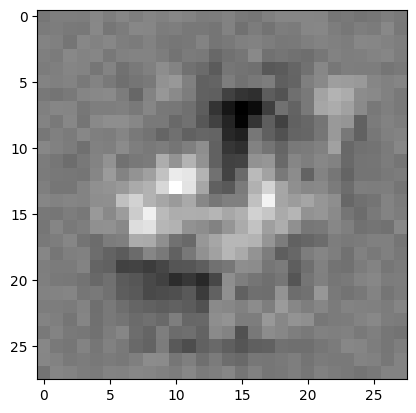

Epoch[92/100], loss: 0.182679, acc: 0.967000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


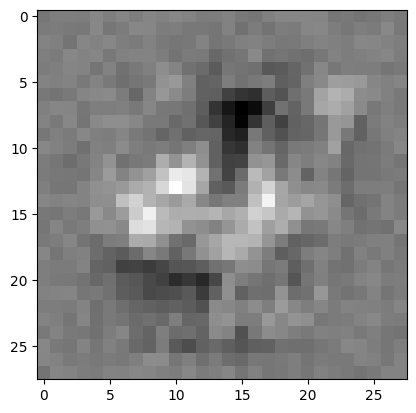

Epoch[93/100], loss: 0.182075, acc: 0.967000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


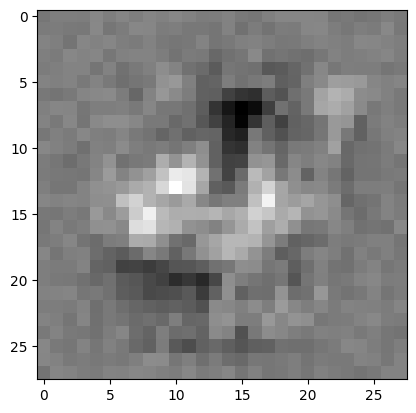

Epoch[94/100], loss: 0.181475, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


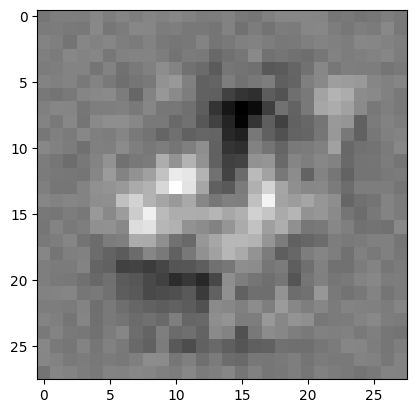

Epoch[95/100], loss: 0.180879, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


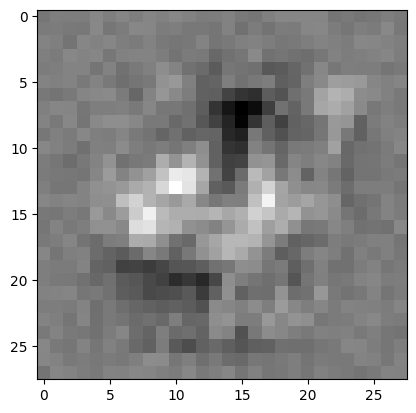

Epoch[96/100], loss: 0.180287, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


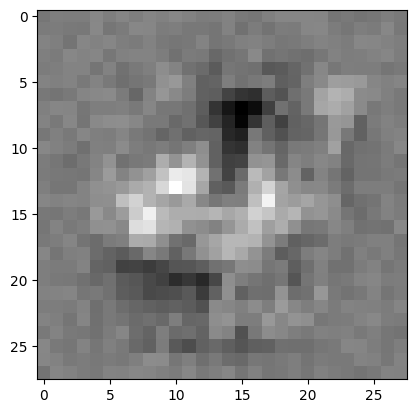

Epoch[97/100], loss: 0.179698, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


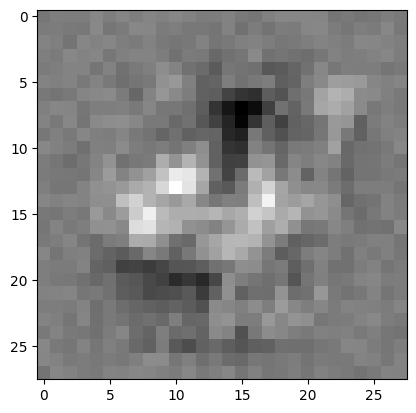

Epoch[98/100], loss: 0.179113, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


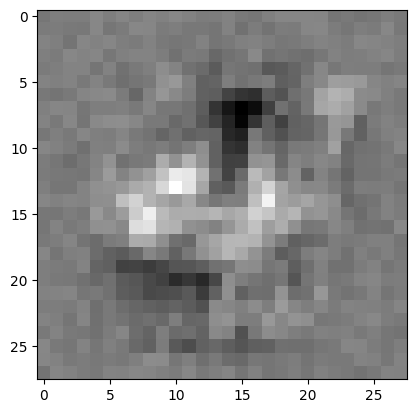

Epoch[99/100], loss: 0.178532, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


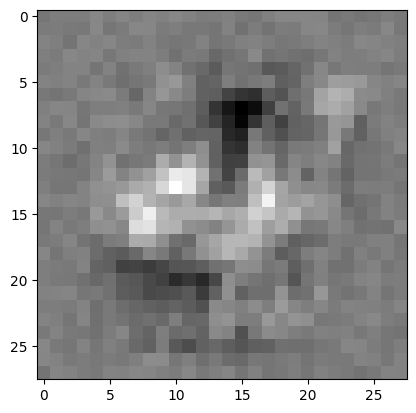

Epoch[100/100], loss: 0.177954, acc: 0.968000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


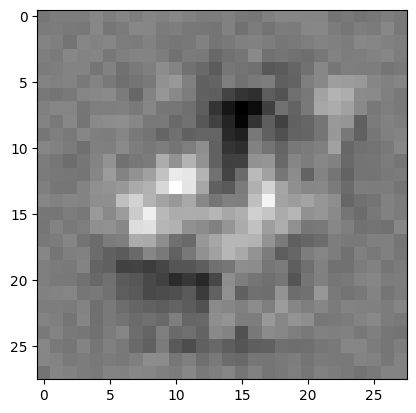

In [43]:
import numpy

losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))

    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()

Pegando do primeiro resultado ao ultimo, saimos de uma condição com loss em 0.26 e acc: 0.940, para o ultimo resultado com loss em 0.178 e acc em 0.968, ficando evidente a melhora do modelo na compreensão da imagem

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
2. Qual é o shape da saída da rede?
3. Qual é o número total de parâmetros da rede, incluindo o bias?

1. Qual é o shape da matriz de entrada na rede?

[1000, 784]

2. Qual é o shape da saída da rede?

[1000, 10]

3. Qual é o número total de parâmetros da rede, incluindo o bias?

7850

# Aprendizados
